### Import Libraries

In [1]:
%matplotlib inline
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

### Set up display

In [2]:
print("GPU available: ", torch.cuda.is_available())
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import  display

GPU available:  True


### Deep Q-Network

In [3]:
## Fully connected layer network
class DQN(nn.Module):
    def __init__(self, img_height, img_width, outputs):
        super().__init__()

        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=128)
        self.out = nn.Linear(in_features=128, out_features=outputs)

    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu_(self.fc1(t))
        t = F.relu_(self.fc2(t))
        t = self.out(t)
        return t


In [4]:
## Fully connected layer network (Dropout)
class DQN(nn.Module):
    def __init__(self, img_height, img_width, outputs):
        super().__init__()

        self.model_drop = nn.Sequential(nn.Linear(in_features=img_height*img_width*3, out_features=128),
                                        #nn.BatchNorm1d(128),
                                        nn.Dropout(0.05),
                                        nn.ReLU(),
                                        nn.Linear(in_features=128, out_features=128),
                                        #nn.BatchNorm1d(128),
                                        nn.Dropout(0.05),
                                        nn.ReLU(),
                                        nn.Linear(in_features=128, out_features=outputs))

    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = self.model_drop(t)
        return t

In [4]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

### Experience Class

In [5]:
Experience = namedtuple('Experience', ('state', 'action', 'next_state', 'reward'))

e = Experience(1,2,3,4)
e

Experience(state=1, action=2, next_state=3, reward=4)

### Replay Memory

In [6]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0

    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):
        return len(self.memory)>= batch_size

### Epsilon Greedy Strategy

In [7]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
        math.exp(-1. * current_step *self.decay)

### Reinforcement Learning Agent

In [8]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device

    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            # self.current_step += 1
            action = random.randrange(self.num_actions)
            return  torch.tensor([action]).to(self.device)  # explore
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device)  # exploit

### Environment Manager

In [9]:
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False

    def reset(self):
        self.env.reset()
        self.current_screen = None

    def close(self):
        self.env.close()

    def render(self, mode='human'):
        return self.env.render(mode)

    def num_actions_available(self):
        return self.env.action_space.n

    def take_action(self, action):
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)

    def just_starting(self):
        return self.current_screen is None

    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1

    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]

    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]

    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # Pytorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)

    def crop_screen(self, screen):
        screen_height = screen.shape[1]

        #  strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen

    def transform_screen_data(self, screen):
        # convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)

        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            , T.Resize((40, 90))
            , T.ToTensor()
        ])

        return resize(screen).unsqueeze(0).to(self.device)

### Example of non-processed screen

d:\anaconda3\envs\gym_tutorial\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


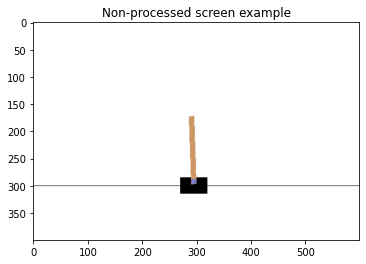

In [10]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()

### Example of processed screen

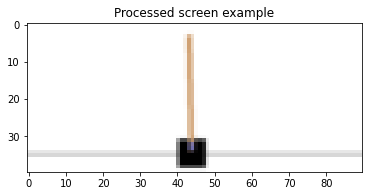

<Figure size 432x288 with 0 Axes>

In [11]:
screen = em.get_processed_screen()
plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Processed screen example')
plt.show()
plt.savefig('screen1.pdf')

### Example of starting state

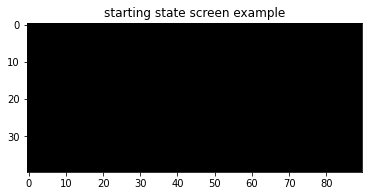

In [23]:
screen = em.get_state()
plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('starting state screen example')
plt.show()


### Example of non-starting state

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


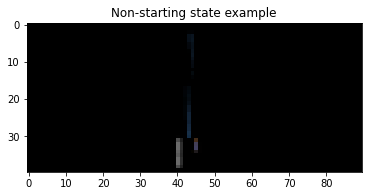

In [13]:
for i in range(5):
    em.take_action(torch.tensor([1]))
screen = em.get_state()


plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Non-starting state example')
plt.show()

### Example of end state

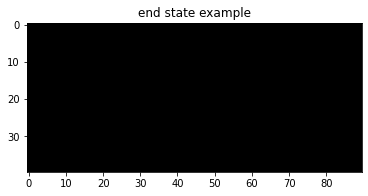

In [14]:
em.done = True
screen = em.get_state()
plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('end state example')
plt.show()

## Utility functions

### Plotting

In [10]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title("Training...")
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)

    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(get_moving_average(moving_avg_period, values))
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
          moving_avg_period, "episode moving avg:", moving_avg[-1])
    print("Current Duration:", values[-1])
    print("Max duration:", np.max(values), "Episode:", np.argmax(values))
    print("Max Avg Period:", np.max(moving_avg), "Episode:", np.argmax(moving_avg))
    if is_ipython: display.clear_output(wait=True)

def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
        .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()


### Tensor Processing


In [11]:
def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

### Q-Value Calculator

In [12]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

    @staticmethod
    def get_next(target_net, next_states):
        final_state_locations = next_states.flatten(start_dim=1) \
        .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values


## Main Program

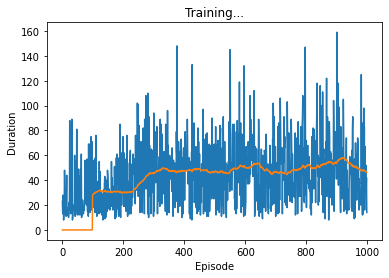

Episode 1000 
 100 episode moving avg: 46.28
Current Duration: 14
Max duration: 159 Episode: 901
Max Avg Period: 58.02 Episode: 917


In [14]:
# Hyper-parameters setting
batch_size = 256
gamma = 0.999
eps_start = 0.9
eps_end = 0.01
eps_decay = 0.001
target_update = 12
memory_size = 100000
lr = 0.0001
num_episodes = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width(), em.num_actions_available()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width(), em.num_actions_available()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)
penalty = 30
episode_durations = []

for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    #if episode % 1000 == 0:
     #   strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
     #   agent = Agent(strategy, em.num_actions_available(), device)
    if episode > 400:
        penalty = 60
    if episode > 600:
        penalty = 90
    if episode > 700:
        penalty = 120
    if episode > 800:
        penalty = 150
    for timestep in count():

        '''if episode == 400:
            lr = 0.00005
            optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)
        elif episode == 750:
            lr = 0.000025
            optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)
        elif episode == 1500:
            lr = 0.000015
            optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)
        elif episode == 1700:
            lr = 0.000005
            optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)
        elif episode == 1800:
            lr = 0.0000025
            optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)
        elif episode == 1900:
            lr = 0.000001
            optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)
        '''
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)

        if em.done:
            if timestep < penalty:
                reward -= 10
            else:
                reward -= 1
        if timestep > 100:
            reward += 1
        if timestep > 150:
            reward += 2
        if timestep > 200:
            reward += 2
        if timestep > 300:
            reward += 3

        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state

        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)

            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values =  (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

In [14]:
params = {'batch_size':batch_size, 'gamma': gamma, 'eps_start': eps_start, 'eps_end': eps_end, 'eps_decay': eps_decay\
          , 'target_net': target_update, 'memory_size':memory_size, 'lr':lr, 'num_episodes': num_episodes}

print(params)

np.save('./params-225-919.npy', params)

{'batch_size': 256, 'gamma': 0.997, 'eps_start': 0.9, 'eps_end': 0.01, 'eps_decay': 0.001, 'target_net': 12, 'memory_size': 100000, 'lr': 5e-05, 'num_episodes': 1000}


In [24]:
durations = {'episode_durations': episode_durations}
np.save('./durations-test6.npy', durations)

In [18]:
plot(episode_durations, 100)

OSError: 'science' not found in the style library and input is not a valid URL or path; see `style.available` for list of available styles